## Homework 6
### Due Friday, 10/25/2024
### 1. 2D Interpolation
Back in Homework 3, we saw an example of scanning-tunnelling miscorscope data in the file stm.txt.  Now let's do some interpolation with this data.

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor

a) First, load the data and pick out every other data point in the x and y directions.  I.e., you should have data points [0,0], [0,2], [0,4], ..., [2,0], [2,2], [2,4], ...  You can look at the lectrure notes on Gaussian Process Regresison for an example how to do this.  You will use this data set to make the interpolation, and the other data points for comparison.

In [23]:
# 1a
data = np.loadtxt("stm-1.txt")
print(f"Original data:\n{data}\n")

data_reduced = data[::2, ::2]
print(f"Reduced data:\n{data_reduced}\n")

Original data:
[[24.28 26.41 28.71 ... 25.88 26.06 25.88]
 [23.93 26.06 28.36 ... 25.7  25.7  25.52]
 [23.22 25.52 27.83 ... 25.35 25.52 25.17]
 ...
 [13.12 13.65 14.18 ... 16.31 16.31 16.31]
 [13.12 13.65 14.18 ... 16.84 17.02 16.84]
 [13.12 13.65 14.   ... 17.37 17.55 17.37]]

Reduced data:
[[24.28 28.71 32.26 ... 25.17 25.7  26.06]
 [23.22 27.83 31.37 ... 24.46 24.99 25.52]
 [21.8  26.94 30.66 ... 23.22 24.11 24.46]
 ...
 [13.29 14.36 14.71 ... 14.18 14.53 14.89]
 [13.12 14.18 14.53 ... 15.42 15.95 16.31]
 [13.12 14.   14.36 ... 16.48 17.02 17.55]]



b) First, do a 2D linear interpolation on the reduced (even) data points.  Use the function scipy.interpolate.RegularGridInterpolator().  Then reconstruct a new version of the entire data set (all points) using this interpolation.  Make a plot of row 300 for both the origional data and the interpolated data.  On average, how far off is the interpolated data?  Do the same thing for row 301.  Why is the data in this row farther off?

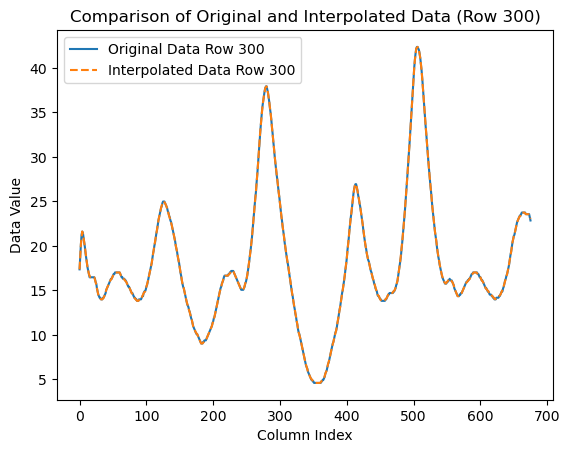

Average difference for row 300: 0.025961538461538522


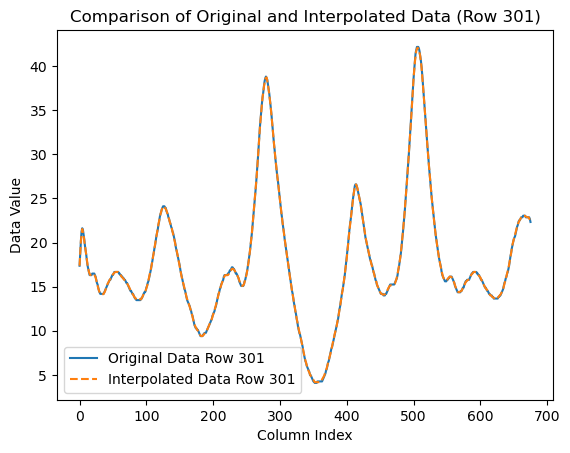

Average difference for row 301: 0.058125000000000045


In [26]:
# 1b
nx, ny = data.shape

x_reduced = np.arange(0, nx, 2)
y_reduced = np.arange(0, ny, 2)

interpolating_function = RegularGridInterpolator((x_reduced, y_reduced), data_reduced, bounds_error=False, fill_value=None)

x_full = np.arange(0, nx)
y_full = np.arange(0, ny)

meshgrid_x, meshgrid_y = np.meshgrid(x_full, y_full, indexing='ij')

points = np.array([meshgrid_x.flatten(), meshgrid_y.flatten()]).T

interpolated_values = interpolating_function(points)

data_interpolated = interpolated_values.reshape(nx, ny)

plt.plot(data[300, :], label='Original Data Row 300')
plt.plot(data_interpolated[300, :], label='Interpolated Data Row 300', linestyle='--')
plt.title('Comparison of Original and Interpolated Data (Row 300)')
plt.xlabel('Column Index')
plt.ylabel('Data Value')
plt.legend()
plt.show()

mean_difference_row_300 = np.mean(np.abs(data[300, :] - data_interpolated[300, :]))
print(f"Average difference for row 300: {mean_difference_row_300}")

plt.plot(data[301, :], label='Original Data Row 301')
plt.plot(data_interpolated[301, :], label='Interpolated Data Row 301', linestyle='--')
plt.title('Comparison of Original and Interpolated Data (Row 301)')
plt.xlabel('Column Index')
plt.ylabel('Data Value')
plt.legend()
plt.show()

mean_difference_row_301 = np.mean(np.abs(data[301, :] - data_interpolated[301, :]))
print(f"Average difference for row 301: {mean_difference_row_301}")

Row 301 is less accurate because it wasn't included in the reduced data used for interpolation, so its values are estimated between known points. This leads to greater differences.

c) Repeat part b) using cubic interpoalation.  You can still use scipy.interpolate.RegularGridInterpolator() with the option method='cubic'.

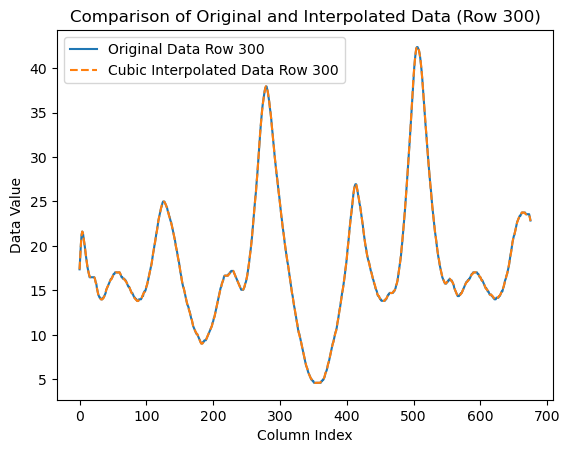

Average difference for row 300: 0.028058982294107644


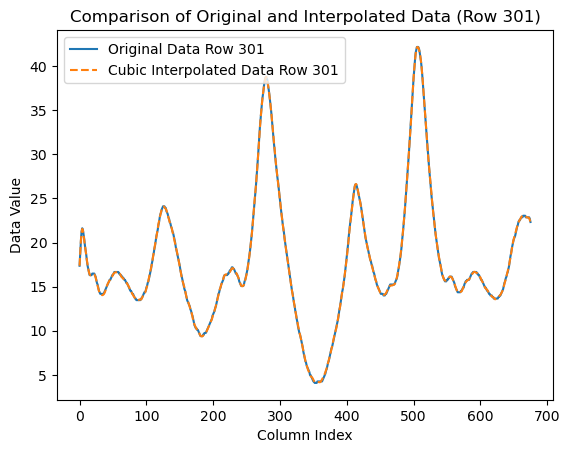

Average difference for row 301: 0.061415656971875704


In [30]:
# 1c
interpolating_function = RegularGridInterpolator(
    (x_reduced, y_reduced), data_reduced, method='cubic', bounds_error=False, fill_value=None
)

interpolated_values = interpolating_function(points)

data_interpolated = interpolated_values.reshape(nx, ny)

plt.plot(data[300, :], label='Original Data Row 300')
plt.plot(data_interpolated[300, :], label='Cubic Interpolated Data Row 300', linestyle='--')
plt.title('Comparison of Original and Interpolated Data (Row 300)')
plt.xlabel('Column Index')
plt.ylabel('Data Value')
plt.legend()
plt.show()

mean_difference_row_300 = np.mean(np.abs(data[300, :] - data_interpolated[300, :]))
print(f"Average difference for row 300: {mean_difference_row_300}")

plt.plot(data[301, :], label='Original Data Row 301')
plt.plot(data_interpolated[301, :], label='Cubic Interpolated Data Row 301', linestyle='--')
plt.title('Comparison of Original and Interpolated Data (Row 301)')
plt.xlabel('Column Index')
plt.ylabel('Data Value')
plt.legend()
plt.show()

mean_difference_row_301 = np.mean(np.abs(data[301, :] - data_interpolated[301, :]))
print(f"Average difference for row 301: {mean_difference_row_301}")

d) Now repeate part b) using gaussian proces regression.  Be sure to include the errors in your plot using the sigma returned by the GPR and the fill_between() function.  How does the accuracy compare to cubic interpolation?  How does the actual error compare to the sigma from the GPR?

Number of training samples: 7055
Fitting the GPR model...
Predicting on rows 300 and 301...


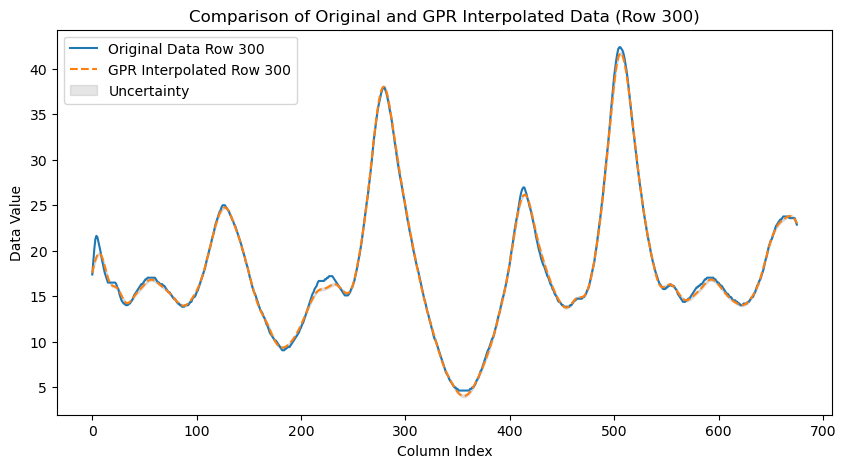

Average difference for row 300: 0.2268511405233395
Average predicted uncertainty (sigma) for row 300: 0.12858740993936463


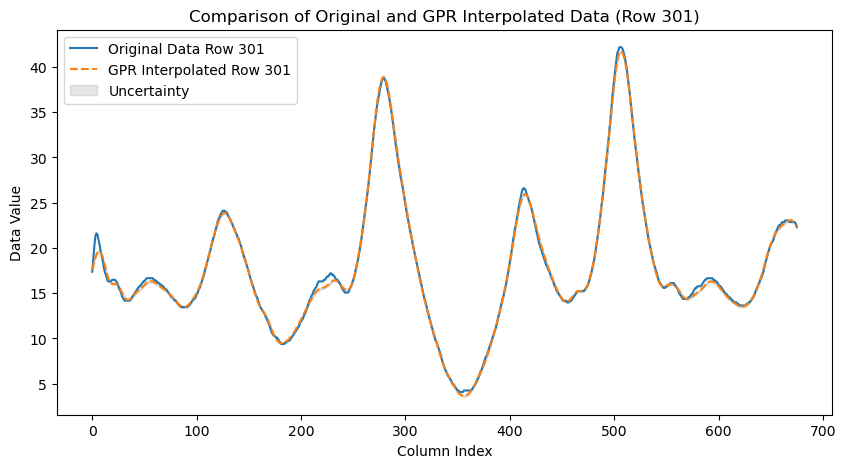

Average difference for row 301: 0.2155817030025321
Average predicted uncertainty (sigma) for row 301: 0.12305801071569165


In [33]:
# 1d
step_size = 8
x_reduced = np.arange(0, nx, step_size)
y_reduced = np.arange(0, ny, step_size)
data_reduced = data[::step_size, ::step_size]

X_reduced_grid, Y_reduced_grid = np.meshgrid(x_reduced, y_reduced, indexing='ij')
X_reduced = np.column_stack([X_reduced_grid.ravel(), Y_reduced_grid.ravel()])
y_reduced = data_reduced.ravel()

print(f"Number of training samples: {X_reduced.shape[0]}")

scaler = MinMaxScaler()
X_reduced_scaled = scaler.fit_transform(X_reduced)

kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-7, 1e5), nu=1.5)

gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=5)

print("Fitting the GPR model...")
gpr.fit(X_reduced_scaled, y_reduced)

rows_of_interest = [300, 301]
X_pred_list = []
for row in rows_of_interest:
    x_coords = np.full(ny, row)
    y_coords = np.arange(0, ny)
    X_pred_row = np.column_stack([x_coords, y_coords])
    X_pred_list.append(X_pred_row)

X_pred = np.vstack(X_pred_list)
X_pred_scaled = scaler.transform(X_pred)

print("Predicting on rows 300 and 301...")
y_pred, sigma = gpr.predict(X_pred_scaled, return_std=True)

data_interpolated_rows = {}
sigma_interpolated_rows = {}
for idx, row in enumerate(rows_of_interest):
    start = idx * ny
    end = (idx + 1) * ny
    data_interpolated_rows[row] = y_pred[start:end]
    sigma_interpolated_rows[row] = sigma[start:end]

for row in rows_of_interest:
    plt.figure(figsize=(10, 5))
    plt.plot(data[row, :], label=f'Original Data Row {row}')
    plt.plot(data_interpolated_rows[row], label=f'GPR Interpolated Row {row}', linestyle='--')
    plt.fill_between(
        np.arange(ny),
        data_interpolated_rows[row] - sigma_interpolated_rows[row],
        data_interpolated_rows[row] + sigma_interpolated_rows[row],
        color='gray', alpha=0.2, label='Uncertainty'
    )
    plt.title(f'Comparison of Original and GPR Interpolated Data (Row {row})')
    plt.xlabel('Column Index')
    plt.ylabel('Data Value')
    plt.legend()
    plt.show()

    mean_difference = np.mean(np.abs(data[row, :] - data_interpolated_rows[row]))
    mean_sigma = np.mean(sigma_interpolated_rows[row])
    print(f"Average difference for row {row}: {mean_difference}")
    print(f"Average predicted uncertainty (sigma) for row {row}: {mean_sigma}")

Compared to cubic interpolation, GPR in part d has lower accuracy, and its sigma is smaller than the actual errors.

e) Finally, repeate part d), but include an error on each point of 0.005, the rounding error on the data.  Compare the sigma returned by the GPR and the difference between the real and interpolated values in parts d) and e).

Fitting the GPR model with observation noise...
Predicting on rows 300 and 301 with observation noise...


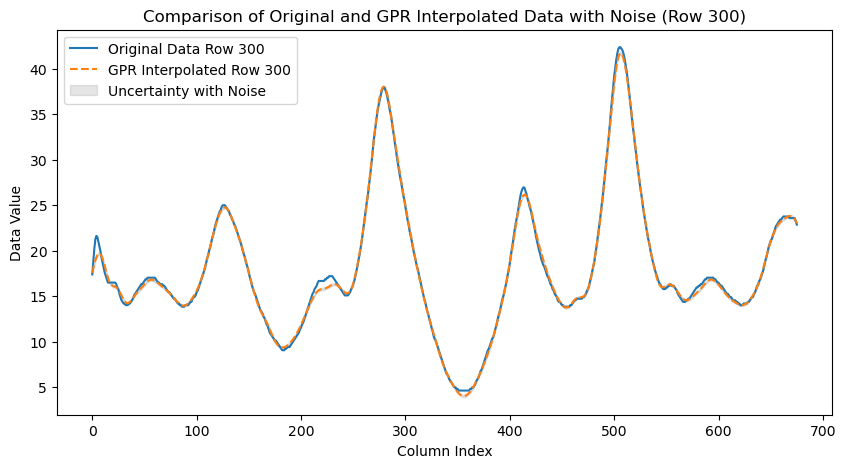

Average difference for row 300 (with noise): 0.2268436382937785
Average predicted uncertainty (sigma) for row 300 (with noise): 0.12862852232645533


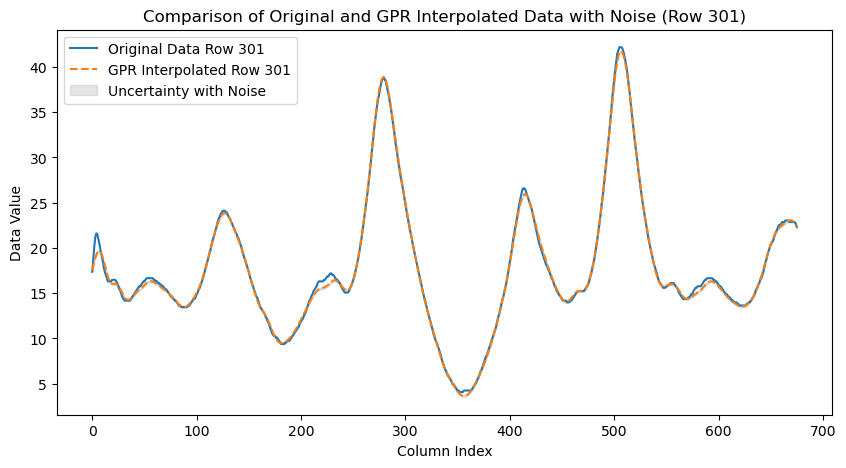

Average difference for row 301 (with noise): 0.21555191961957088
Average predicted uncertainty (sigma) for row 301 (with noise): 0.12310601239207722


In [35]:
# 1e
alpha_value = 0.005**2  # Variance of the observation noise
gpr = GaussianProcessRegressor(
    kernel=kernel,
    random_state=0,
    n_restarts_optimizer=5,
    alpha=alpha_value
)

print("Fitting the GPR model with observation noise...")
gpr.fit(X_reduced_scaled, y_reduced)

rows_of_interest = [300, 301]
X_pred_list = []
for row in rows_of_interest:
    x_coords = np.full(ny, row)
    y_coords = np.arange(0, ny)
    X_pred_row = np.column_stack([x_coords, y_coords])
    X_pred_list.append(X_pred_row)

X_pred = np.vstack(X_pred_list)
X_pred_scaled = scaler.transform(X_pred)

print("Predicting on rows 300 and 301 with observation noise...")
y_pred, sigma = gpr.predict(X_pred_scaled, return_std=True)

data_interpolated_rows_e = {}
sigma_interpolated_rows_e = {}
for idx, row in enumerate(rows_of_interest):
    start = idx * ny
    end = (idx + 1) * ny
    data_interpolated_rows_e[row] = y_pred[start:end]
    sigma_interpolated_rows_e[row] = sigma[start:end]

for row in rows_of_interest:
    plt.figure(figsize=(10, 5))
    plt.plot(data[row, :], label=f'Original Data Row {row}')
    plt.plot(data_interpolated_rows_e[row], label=f'GPR Interpolated Row {row}', linestyle='--')
    plt.fill_between(
        np.arange(ny),
        data_interpolated_rows_e[row] - sigma_interpolated_rows_e[row],
        data_interpolated_rows_e[row] + sigma_interpolated_rows_e[row],
        color='gray', alpha=0.2, label='Uncertainty with Noise'
    )
    plt.title(f'Comparison of Original and GPR Interpolated Data with Noise (Row {row})')
    plt.xlabel('Column Index')
    plt.ylabel('Data Value')
    plt.legend()
    plt.show()

    # Calculate the average difference and predicted uncertainty
    mean_difference_e = np.mean(np.abs(data[row, :] - data_interpolated_rows_e[row]))
    mean_sigma_e = np.mean(sigma_interpolated_rows_e[row])
    print(f"Average difference for row {row} (with noise): {mean_difference_e}")
    print(f"Average predicted uncertainty (sigma) for row {row} (with noise): {mean_sigma_e}")

Including an error of 0.005 in the GPR model did not significantly change the sigma values or the differences between the real and interpolated values compared to part d.